# Explorando outros tipos de regressões - Árvore de Regressão

Quando estudamos estatística, econometria ou machine learning, um dos primeiros assuntos que aprendemos (pelo menos falando de modelos preditivos), é a regressão linear. E não me entenda mal, a regressão linear padrão pode ser uma ferramenta muito poderosa, e mesmo que não replique idealmente a realidade na maioria das vezes, pode ao menos dar um método para a nossa tomada de decisão na ausência da possibilidade da criação de um modelo mais robusto, por exemplo.

Porém, mesmo apesar de a regressão linear ter o seu valor, ela não deixa de ser um algoritmo bem simples e, querendo ou não, limitado. Justamente por isso, vale muito a pena explorar outros tipos de algoritmos de regressão, como  as **árvores de regressão**, ou até mesmo, a derivação da árvore de regressão que seria a **floresta aleatória de regressão**, e o mais interessante desses algoritmos é que eles não ficam limitados a plotar uma reta, ou seja, a gente começa a abandonar a simplicidade de uma linearidade que é trazida pela regressão linear padrão.

Para isso, vou criar um dataset hipotético, que não seguirá uma relação linear, e mostrar como a regressão linear normal não seria a abordagem ideal para um problema como esse...

*Antes de iniciarmos, uma ressalva*: Para de fato entender como funciona uma árvore de regressão ou uma floresta aleatória de regressão, recomendo que você primeiro entenda o que é uma árvore de decisão. Para isso, sinta-se livre para ler meu outro notebook sobre o assunto, e depois volte neste!

## Gerando um dataset:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

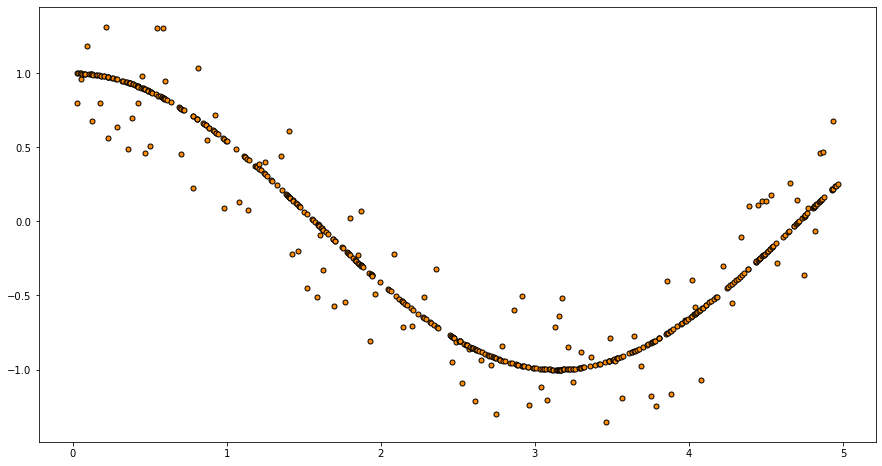

In [2]:
# Criando um dataset a aleatório:

# Usando Numpy para criar dois vetores aleatoriamente
rng = np.random.RandomState(42)
X = np.sort(5 * rng.rand(500, 1), axis=0)
y = np.cos(X).ravel()
y[::5] += 1*(0.5 - rng.rand(100))

# Colocando os vetores em um DataFrame
df = pd.DataFrame({'X': X.ravel(), 'y': y})

# Plotando os dados:
plt.figure(figsize=(15,8))
plt.scatter(df['X'], df['y'], s=25, edgecolor="black", c="darkorange", label="data")

Veja que esse Dataset criado acima realmente não parece possuir uma correlação que poderia ser facilmente replicada por uma regressão linear simples. E a solução que eu vou dar pra esse problema agora é a **Árvore de Regressão**!

## A árvore de regressão

Como sempre, primeiramente vou tentar dar uma explicação teórica de como uma árvore de regressão funciona, tentando ser sucinto a ponto de não entrar no máximo detalhe, mas também tentando não deixar nenhum ponto importante de fora.

A **árvore de regressão não deixa de ser uma árvore de decisão**, quero deixar isso bem claro, mas enquanto a maioria das pessoas está acostumada a ver árvores de decisão sendo usadas para classificação, as vezes usamos árvores de decisão e árvore de classificação como sinônimos, mas isso não é totalmente correto! O correto é: **tanto a árvore de regressão quanto a árvore de classificação são árvores de decisão**. Porém, e é aí que está a diferença, enquanto a árvore de classificação nos retorna *outputs* categóricos, a **árvore de regressão vai nos retornar *outputs* numéricos**!

Da mesma forma que a árvore de classificação vai criando *nodes* de acordo com a minimização da entropia, a **árvore de regressão vai criar *nodes* tentando minimizar o SSR (Squared Sum of Residuals)**. E isso é feito da seguinte forma:

- Imagine que estamos "caminhando" pelo nosso dataset, da esquerda para a direita...
- A árvore de regressão vai separar o nosso dataset em 2, para cada ponto pelo qual estamos caminhando...
- A partir de uma separação, teremos um valor médio para a esquerda e um valor médio para a direita...
- Se assumirmos que cada um desses valores médios forem nossos outputs (nódulos folha), poderemos então calcular o SSR do modelo...
- Vamos fazendo essa separação ponto a ponto até encontrarmos a separação que nos retorne o menor SSR, criando assim, como se fossem 2 grupos de dados do nosso dataset...
- Quando encontrarmos, teremos o nosso *root node*, e então tentaremos separar esse primeiro grupo, "que ficaria ao lado esquerdo do gráfico, na nossa caminhada", até separarmos ele por uma quantidade pré-determinada como parâmetro de nosso modelo...
- E assim por diante, iremos ficar separando os dados, como se fossem "grupos", tentando sempre minimizar o SSR, de forma que a resposta na folha, sempre será o valor médio de cada grupo!

**Eu sei que essa explicação pode ter parecido meio esotérica**, e, para solução disso, como sempre, irei deixar alguns materiais de referência no final do notebook, mas, por ora, peço que continue me acompanhando pois talvez algumas coisa irão ficando mais claras ao longo do caminho.

## Iniciando a modelagem...

Vou colocar a modelagem em prática para tentar deixar as coisas mais claras por meio da praticidade:

### Train-Test-Split

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop('y',axis=1) # Variáveis explicativas
y = df['y'] # O que estamos querendo prever

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Fitando o Modelo:

Primeiro, vou simplesmente fitar o modelo sem medo de ser feliz, e depois mostrar um eventual problema que isso pode causar:

In [4]:
from sklearn.tree import DecisionTreeRegressor

modelo_ar_1 = DecisionTreeRegressor()
modelo_ar_1.fit(X_train, y_train)

DecisionTreeRegressor()

### Usando para previsões:

In [5]:
previsoes_1 = modelo_ar_1.predict(X_test)
previsoes_1_treino = modelo_ar_1.predict(X_train)

In [6]:
from sklearn import metrics as mtrc
erro_teste = mtrc.mean_squared_error(y_test, previsoes_1)
erro_treino = mtrc.mean_squared_error(y_train, previsoes_1_treino)

print(f'O nosso erro no ambiente de treino foi de {erro_treino} e no ambiente de teste foi de {round(erro_teste,4)}')

O nosso erro no ambiente de treino foi de 0.0 e no ambiente de teste foi de 0.0311


Os nossos resultados acima podem representar um problema... **O fato de nosso modelo ter um MSE de 0 no ambiente de teste pode nos indicar um claro e sério problema de *overfitting*!** E isso está acontecendo pelo fato de eu não ter settado nenhum parâmetro no objeto `DecisionTreeRegressor()`, permitindo que nossa árvore cresça sem parar até que ela consiga separar o nosso dataset o máximo possível. Uma possível saída para esse problema, é settar o parâmetro `max_depth`, que vai limitar o crescimento de nossa árvore, porém, não é a única saída!

In [7]:
# Criando um modelo com max_depth de 5:

modelo_ar_2 = DecisionTreeRegressor(max_depth=5)
modelo_ar_2.fit(X_train, y_train)
previsoes_2 = modelo_ar_2.predict(X_test)
previsoes_2_treino = modelo_ar_2.predict(X_train)

erro_teste_2 = mtrc.mean_squared_error(y_test, previsoes_2)
erro_treino_2 = mtrc.mean_squared_error(y_train, previsoes_2_treino)

print(f'O nosso erro no ambiente de treino foi de {round(erro_treino_2,5)} \
e no ambiente de teste foi de {round(erro_teste_2,5)} \
com uma árvore de {modelo_ar_2.get_depth()} de profundidade!')

O nosso erro no ambiente de treino foi de 0.01344 e no ambiente de teste foi de 0.02383 com uma árvore de 5 de profundidade!


Veja que coisa interessante aconteceu ao settar a nossa profundidade máxima para 5! O nosso erro no treino aumentou, como já era esperado, porém o nosso erro no teste, que é o que importa, diminuiu!!! Vamos ver o que acontece se eu mudar novamente...

In [8]:
# Criando um modelo com max_depth de 3:

modelo_ar_3 = DecisionTreeRegressor(max_depth=3)
modelo_ar_3.fit(X_train, y_train)
previsoes_3 = modelo_ar_3.predict(X_test)
previsoes_3_treino = modelo_ar_3.predict(X_train)

erro_teste_3 = mtrc.mean_squared_error(y_test, previsoes_3)
erro_treino_3 = mtrc.mean_squared_error(y_train, previsoes_3_treino)

print(f'O nosso erro no ambiente de treino foi de {round(erro_treino_3,5)} \
e no ambiente de teste foi de {round(erro_teste_3,5)} \
com uma árvore de {modelo_ar_3.get_depth()} de profundidade!')

O nosso erro no ambiente de treino foi de 0.03003 e no ambiente de teste foi de 0.03889 com uma árvore de 3 de profundidade!


Veja que agora tanto o erro do treino quanto o do teste aumentaram em relação ao modelo "_2". Mas beleza, uma pergunta que você poderia me fazer agora é: **Como decidimos a profundidade, ou o parâmetro que devemos usar?**

E a resposta é: podemos fazer isso através da **validação cruzada**, que basicamente consiste em tentar diferentes parâmetros, de forma automática, para encontrar o melhor de todos!

*Obs.: Para árvores de regressão e classificação, existem metodologias específicas para ajustes de parâmetro, e principalmente para verificação da melhor profundidade de sua árvore, uma delas é a **Cost Complexity Pruning Path**, que eu não abordarei neste notebook, mas deixarei um link no apêndice para você aprender sobre o que se trata, e já adianto que inclusive existe um método já embutido no `scikit-learn` para fazer isso*

### Ajustando hiperparâmetros por meio da validação cruzada

Agora, vamos achar quais são os parâmetros ideais para o nosso modelo...

Para realizar a validação cruzada, a primeira coisa que eu recomendo fazer é estudar todos os parâmetros que podem influenciar seu modelo para você consiga definir quais valem a pena ser mudados. Depois disso, faça um dicionário semelhante ao que eu vou mostrar a seguir, com as diferentes opções dos parâmetros que você acha que valham a pena ser testados:

In [9]:
# Diferentes parâmetros que podemos mudar:

'''
DecisionTreeRegressor(
    *,
    criterion='mse',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    presort='deprecated',
    ccp_alpha=0.0,
)

'''

# As diferentes combinações que vou testar:

parametros = {
    'splitter': ['best', 'random'],
    'max_depth': [2, 3, 4, 5, 7, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10, 20, 40, 50],
    'min_samples_leaf': [2, 5, 10, 20, 40, 50]
}

# Em um caso real, com um dataset grande e mais complexo, esse processo pode demorar e precisar de bastante poder computacional!


In [10]:
from sklearn.model_selection import GridSearchCV

# Instancio um novo regressor:
modelo_ar_cv = DecisionTreeRegressor()

# Faço um modelo de validação cruzada:
modelo_cv = GridSearchCV(estimator=modelo_ar_cv,
                        param_grid=parametros,
                        cv=5,
                        verbose=4)

In [11]:
modelo_cv.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best, score=0.782, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best, score=0.778, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best, score=0.798, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best, score=0.859, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=2, splitter=best, score=0.821, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=2, min_samples_leaf=2, min_samples_split=40, splitter=random 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=40, splitter=random, score=0.694, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=40, splitter=random 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=40, splitter=random, score=0.638, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=40, splitter=random 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=40, splitter=random, score=0.752, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=40, splitter=random 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=40, splitter=random, score=0.199, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=50, splitter=best 
[CV]  max_depth=2, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.782, total=   0.0s
[CV] max_depth=2, min_samples_leaf=2, min_samples_split=50, splitter=best 
[CV]  max_depth=2,

[CV] max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=best 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=best, score=0.798, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=best 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=best, score=0.859, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=best 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=best, score=0.821, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=random 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=random, score=0.586, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=random 
[CV]  max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=random, score=0.357, total=   0.0s
[CV] max_depth=2, min_samples_leaf=5, min_samples_split=20, splitter=random 
[CV]  max_depth=2, min_sa

[CV] max_depth=2, min_samples_leaf=10, min_samples_split=5, splitter=random 
[CV]  max_depth=2, min_samples_leaf=10, min_samples_split=5, splitter=random, score=0.497, total=   0.0s
[CV] max_depth=2, min_samples_leaf=10, min_samples_split=5, splitter=random 
[CV]  max_depth=2, min_samples_leaf=10, min_samples_split=5, splitter=random, score=0.404, total=   0.0s
[CV] max_depth=2, min_samples_leaf=10, min_samples_split=10, splitter=best 
[CV]  max_depth=2, min_samples_leaf=10, min_samples_split=10, splitter=best, score=0.782, total=   0.0s
[CV] max_depth=2, min_samples_leaf=10, min_samples_split=10, splitter=best 
[CV]  max_depth=2, min_samples_leaf=10, min_samples_split=10, splitter=best, score=0.778, total=   0.0s
[CV] max_depth=2, min_samples_leaf=10, min_samples_split=10, splitter=best 
[CV]  max_depth=2, min_samples_leaf=10, min_samples_split=10, splitter=best, score=0.798, total=   0.0s
[CV] max_depth=2, min_samples_leaf=10, min_samples_split=10, splitter=best 
[CV]  max_depth=2, m

[CV]  max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=best, score=0.859, total=   0.0s
[CV] max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=best 
[CV]  max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=best, score=0.821, total=   0.0s
[CV] max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=random 
[CV]  max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=random, score=0.196, total=   0.0s
[CV] max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=random 
[CV]  max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=random, score=0.669, total=   0.0s
[CV] max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=random 
[CV]  max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=random, score=0.527, total=   0.0s
[CV] max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=random 
[CV]  max_depth=2, min_samples_leaf=20, min_samples_split=2, splitter=random, score=0.584, total

[CV]  max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random, score=0.583, total=   0.0s
[CV] max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random 
[CV]  max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random, score=-0.019, total=   0.0s
[CV] max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random 
[CV]  max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random, score=-0.005, total=   0.0s
[CV] max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random 
[CV]  max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random, score=0.761, total=   0.0s
[CV] max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random 
[CV]  max_depth=2, min_samples_leaf=40, min_samples_split=20, splitter=random, score=0.657, total=   0.0s
[CV] max_depth=2, min_samples_leaf=40, min_samples_split=40, splitter=best 
[CV]  max_depth=2, min_samples_leaf=40, min_samples_split=40, splitter=best, sco

[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=best, score=0.723, total=   0.0s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=best 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=best, score=0.732, total=   0.0s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=best 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=best, score=0.825, total=   0.0s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=best 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=best, score=0.793, total=   0.0s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=random 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=random, score=0.608, total=   0.0s
[CV] max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=random 
[CV]  max_depth=2, min_samples_leaf=50, min_samples_split=10, splitter=random, score=-0.019, t

[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random, score=0.853, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random, score=0.947, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=2, splitter=random, score=0.931, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, splitter=best 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, splitter=best, score=0.909, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, splitter=best 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, splitter=best, score=0.930, total=   0.0s
[CV] max_depth=3, min_samples_leaf=2, min_samples_split=5, splitter=best 
[CV]  max_depth=3, min_samples_leaf=2, min_samples_split=5, splitter=best, score=0.894, total=   0.0s
[CV] max

[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, splitter=random, score=0.866, total=   0.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=5, splitter=random 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=5, splitter=random, score=-0.000, total=   0.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, splitter=best 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, splitter=best, score=0.909, total=   0.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, splitter=best 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, splitter=best, score=0.930, total=   0.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, splitter=best 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, splitter=best, score=0.894, total=   0.0s
[CV] max_depth=3, min_samples_leaf=5, min_samples_split=10, splitter=best 
[CV]  max_depth=3, min_samples_leaf=5, min_samples_split=10, splitter=best, score=0.902, total=   0.0s
[CV

[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.943, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random, score=0.622, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random, score=0.815, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random, score=0.649, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random, score=0.518, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=2, splitter=random, score=0.663, t

[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=best, score=0.919, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=best, score=0.888, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=best, score=0.898, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=best, score=0.944, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=random 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=random, score=0.710, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=random 
[CV]  max_depth=3, min_samples_leaf=10, min_samples_split=50, splitter=random, score=0.674, to

[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=20, splitter=random, score=0.748, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=20, splitter=random 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=20, splitter=random, score=0.861, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=20, splitter=random 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=20, splitter=random, score=-0.000, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.903, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.927, total=   0.0s
[CV] max_depth=3, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=3, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.894,

[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random, score=-0.011, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random, score=0.544, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random, score=0.157, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random, score=-0.009, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=10, splitter=random, score=0.785, total=   0.0s
[CV] max_depth=3, min_samples_leaf=40, min_samples_split=20, splitter=best 
[CV]  max_depth=3, min_samples_leaf=40, min_samples_split=20, splitter=best, sco

[CV]  max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random, score=-0.011, total=   0.0s
[CV] max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random, score=-0.019, total=   0.0s
[CV] max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random, score=0.095, total=   0.0s
[CV] max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random, score=-0.009, total=   0.0s
[CV] max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=3, min_samples_leaf=50, min_samples_split=50, splitter=random, score=0.603, total=   0.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=best 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=2, splitter=best, score=

[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=40, splitter=random, score=0.845, total=   0.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.894, total=   0.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.941, total=   0.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.912, total=   0.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.918, total=   0.0s
[CV] max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.947, total=   0.0s
[CV] 

[CV]  max_depth=4, min_samples_leaf=5, min_samples_split=50, splitter=random, score=0.935, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.910, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.961, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.920, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.934, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.946, total=   0.0s
[CV] 

[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.228, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.930, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.853, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.946, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=40, splitter=random, score=-0.000, total=   0.0s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=50, splitter=best, scor

[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.950, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=best 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.919, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=best 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.928, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=best 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.945, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=random 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=random, score=0.683, total=   0.0s
[CV] max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=random 
[CV]  max_depth=4, min_samples_leaf=20, min_samples_split=20, splitter=random, score=0.542, to

[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=5, splitter=random, score=0.700, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=5, splitter=random 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=5, splitter=random, score=0.286, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=5, splitter=random 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=5, splitter=random, score=0.791, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=10, splitter=best 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=10, splitter=best, score=0.843, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=10, splitter=best 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=10, splitter=best, score=0.884, total=   0.0s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=10, splitter=best 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=10, splitter=best, score=0.843, total

[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=best, score=0.878, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=best 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=random, score=0.050, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=random, score=0.701, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=random, score=0.511, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=2, splitter=random, score=-0.009, tota

[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.842, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.857, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.812, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.878, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=4, min_samples_leaf=50, min_samples_split=50, splitter=random, score=0.644, total=

[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=20, splitter=random, score=0.857, total=   0.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=20, splitter=random 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=20, splitter=random, score=0.939, total=   0.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=20, splitter=random 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=20, splitter=random, score=0.892, total=   0.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=20, splitter=random 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=20, splitter=random, score=0.554, total=   0.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=40, splitter=best 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=40, splitter=best, score=0.919, total=   0.0s
[CV] max_depth=5, min_samples_leaf=2, min_samples_split=40, splitter=best 
[CV]  max_depth=5, min_samples_leaf=2, min_samples_split=40, splitter=best, score=0.952, total= 

[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=best, score=0.936, total=   0.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=best 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=best, score=0.961, total=   0.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=best 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=best, score=0.956, total=   0.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=random 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=random, score=0.910, total=   0.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=random 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=random, score=0.888, total=   0.0s
[CV] max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=random 
[CV]  max_depth=5, min_samples_leaf=5, min_samples_split=10, splitter=random, score=0.889, total=   

[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best, score=0.936, total=   0.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best, score=0.964, total=   0.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best, score=0.936, total=   0.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best, score=0.957, total=   0.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=best, score=0.954, total=   0.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=5, splitter=random 
[CV]  max_depth=5, min_samples_le

[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=50, splitter=random, score=0.829, total=   0.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=50, splitter=random 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=50, splitter=random, score=0.844, total=   0.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=50, splitter=random 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=50, splitter=random, score=0.669, total=   0.0s
[CV] max_depth=5, min_samples_leaf=10, min_samples_split=50, splitter=random 
[CV]  max_depth=5, min_samples_leaf=10, min_samples_split=50, splitter=random, score=-0.000, total=   0.0s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=2, splitter=best 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=2, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=2, splitter=best 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=2, splitter=best, score=0.951,

[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.944, total=   0.0s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.946, total=   0.0s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=random 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=random, score=0.742, total=   0.0s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=random 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=random, score=0.712, total=   0.0s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=random 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=random, score=0.844, total=   0.0s
[CV] max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=random 
[CV]  max_depth=5, min_samples_leaf=20, min_samples_split=40, splitter=random, score=0

[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=10, splitter=random, score=0.764, total=   0.0s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best, score=0.844, total=   0.0s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best, score=0.884, total=   0.0s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best, score=0.854, total=   0.0s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best, score=0.897, total=   0.0s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=20, splitter=best, score=0.921, total=  

[CV]  max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=best, score=0.812, total=   0.0s
[CV] max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=best 
[CV]  max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=best, score=0.878, total=   0.0s
[CV] max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=best 
[CV]  max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=random 
[CV]  max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=random, score=0.554, total=   0.0s
[CV] max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=random 
[CV]  max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=random, score=0.709, total=   0.0s
[CV] max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=random 
[CV]  max_depth=5, min_samples_leaf=50, min_samples_split=10, splitter=random, score=0.770

[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.939, total=   0.0s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=best 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.951, total=   0.0s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=random, score=0.909, total=   0.0s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=random, score=0.914, total=   0.0s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=random, score=0.897, total=   0.0s
[CV] max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=7, min_samples_leaf=2, min_samples_split=50, splitter=random, score=0.925, total

[CV]  max_depth=7, min_samples_leaf=5, min_samples_split=50, splitter=random, score=0.841, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.930, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.969, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.939, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.959, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.955, total=   0.0s
[CV] 

[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.763, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.904, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=50, splitter=best, score=0.908, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=50, splitter=best, score=0.948, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=50, splitter=best, score=0.926, total=   0.0s
[CV] max_depth=7, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=7, min_samples_leaf=10, min_samples_split=50, splitter=best, score=0.939, tota

[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=20, splitter=random, score=-0.000, total=   0.0s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.915, total=   0.0s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.953, total=   0.0s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.928, total=   0.0s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.946, total=   0.0s
[CV] max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best 
[CV]  max_depth=7, min_samples_leaf=20, min_samples_split=40, splitter=best, score=0.945, total= 

[CV]  max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random, score=0.714, total=   0.0s
[CV] max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random 
[CV]  max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random, score=0.834, total=   0.0s
[CV] max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random 
[CV]  max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random, score=-0.005, total=   0.0s
[CV] max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random 
[CV]  max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random, score=0.529, total=   0.0s
[CV] max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random 
[CV]  max_depth=7, min_samples_leaf=40, min_samples_split=10, splitter=random, score=-0.000, total=   0.0s
[CV] max_depth=7, min_samples_leaf=40, min_samples_split=20, splitter=best 
[CV]  max_depth=7, min_samples_leaf=40, min_samples_split=20, splitter=best, sco

[CV]  max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=best, score=0.812, total=   0.0s
[CV] max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=best 
[CV]  max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=best, score=0.878, total=   0.0s
[CV] max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=best 
[CV]  max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=random, score=0.607, total=   0.0s
[CV] max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=random, score=0.027, total=   0.0s
[CV] max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=7, min_samples_leaf=50, min_samples_split=20, splitter=random, score=0.723

[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.952, total=   0.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.926, total=   0.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.948, total=   0.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.948, total=   0.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=random 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=random, score=0.932, total=   0.0s
[CV] max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=random 
[CV]  max_depth=10, min_samples_leaf=2, min_samples_split=10, splitter=random, score=0.952, to

[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=best, score=0.962, total=   0.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=best 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=best, score=0.952, total=   0.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=random 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=random, score=0.893, total=   0.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=random 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=random, score=0.955, total=   0.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=random 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=random, score=0.914, total=   0.0s
[CV] max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=random 
[CV]  max_depth=10, min_samples_leaf=5, min_samples_split=5, splitter=random, score=0.894, total

[CV] max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.931, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.967, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.936, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.960, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=best, score=0.953, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=2, splitter=random 
[CV]  max_depth=10, mi

[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.844, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.842, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.928, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.913, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.233, total=   0.0s
[CV] max_depth=10, min_samples_leaf=10, min_samples_split=50, splitter=best 
[CV]  max_depth=10, min_samples_leaf=10, min_samples_split=50, splitter=

[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.928, total=   0.0s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=best 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.946, total=   0.0s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=best 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.945, total=   0.0s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=random 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=random, score=0.723, total=   0.0s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=random 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=random, score=0.433, total=   0.0s
[CV] max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=random 
[CV]  max_depth=10, min_samples_leaf=20, min_samples_split=20, splitter=random, 

[CV] max_depth=10, min_samples_leaf=40, min_samples_split=5, splitter=random 
[CV]  max_depth=10, min_samples_leaf=40, min_samples_split=5, splitter=random, score=0.709, total=   0.0s
[CV] max_depth=10, min_samples_leaf=40, min_samples_split=5, splitter=random 
[CV]  max_depth=10, min_samples_leaf=40, min_samples_split=5, splitter=random, score=0.495, total=   0.0s
[CV] max_depth=10, min_samples_leaf=40, min_samples_split=10, splitter=best 
[CV]  max_depth=10, min_samples_leaf=40, min_samples_split=10, splitter=best, score=0.844, total=   0.0s
[CV] max_depth=10, min_samples_leaf=40, min_samples_split=10, splitter=best 
[CV]  max_depth=10, min_samples_leaf=40, min_samples_split=10, splitter=best, score=0.884, total=   0.0s
[CV] max_depth=10, min_samples_leaf=40, min_samples_split=10, splitter=best 
[CV]  max_depth=10, min_samples_leaf=40, min_samples_split=10, splitter=best, score=0.854, total=   0.0s
[CV] max_depth=10, min_samples_leaf=40, min_samples_split=10, splitter=best 
[CV]  max

[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=best, score=0.878, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=best 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=random, score=-0.011, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=random, score=-0.019, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=random, score=-0.005, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=2, splitter=random, scor

[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=40, splitter=random, score=0.660, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.842, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.857, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.812, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.878, total=   0.0s
[CV] max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best 
[CV]  max_depth=10, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.91

[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=best, score=0.949, total=   0.0s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random, score=0.932, total=   0.0s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random, score=0.908, total=   0.0s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random, score=0.911, total=   0.0s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random, score=0.930, total=   0.0s
[CV] max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random 
[CV]  max_depth=15, min_samples_leaf=2, min_samples_split=50, splitter=random, sco

[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=best, score=0.948, total=   0.0s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=best 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=best, score=0.949, total=   0.0s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=random 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=random, score=0.871, total=   0.0s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=random 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=random, score=0.359, total=   0.0s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=random 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=random, score=0.916, total=   0.0s
[CV] max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=random 
[CV]  max_depth=15, min_samples_leaf=5, min_samples_split=40, splitter=random, score=0

[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best, score=0.931, total=   0.0s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best, score=0.967, total=   0.0s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best, score=0.936, total=   0.0s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best, score=0.960, total=   0.0s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=best, score=0.953, total=   0.0s
[CV] max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=random 
[CV]  max_depth=15, min_samples_leaf=10, min_samples_split=20, splitter=random, score=0.

[CV]  max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random, score=0.828, total=   0.0s
[CV] max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random 
[CV]  max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random, score=0.867, total=   0.0s
[CV] max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random 
[CV]  max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random, score=0.577, total=   0.0s
[CV] max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random 
[CV]  max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random, score=0.674, total=   0.0s
[CV] max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random 
[CV]  max_depth=15, min_samples_leaf=20, min_samples_split=5, splitter=random, score=0.627, total=   0.0s
[CV] max_depth=15, min_samples_leaf=20, min_samples_split=10, splitter=best 
[CV]  max_depth=15, min_samples_leaf=20, min_samples_split=10, splitter=best, sco

[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=best, score=0.884, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=best 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=best, score=0.854, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=best 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=best, score=0.897, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=best 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=best, score=0.921, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=random 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=random, score=0.735, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=random 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=2, splitter=random, score=0.683, to

[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=40, splitter=random, score=-0.005, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=40, splitter=random 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=40, splitter=random, score=-0.009, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=40, splitter=random 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=40, splitter=random, score=-0.000, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=50, splitter=best 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=50, splitter=best, score=0.844, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=50, splitter=best 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=50, splitter=best, score=0.884, total=   0.0s
[CV] max_depth=15, min_samples_leaf=40, min_samples_split=50, splitter=best 
[CV]  max_depth=15, min_samples_leaf=40, min_samples_split=50, splitter=best,

[CV]  max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random, score=-0.011, total=   0.0s
[CV] max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random, score=0.503, total=   0.0s
[CV] max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random, score=0.625, total=   0.0s
[CV] max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random, score=-0.009, total=   0.0s
[CV] max_depth=15, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=15, min_samples_leaf=50, min_samples_split=20, splitte

[CV]  max_depth=20, min_samples_leaf=2, min_samples_split=5, splitter=random, score=0.945, total=   0.0s
[CV] max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.953, total=   0.0s
[CV] max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.926, total=   0.0s
[CV] max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.948, total=   0.0s
[CV] max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=20, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.942, total=   

[CV]  max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best, score=0.907, total=   0.0s
[CV] max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best 
[CV]  max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best, score=0.947, total=   0.0s
[CV] max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best 
[CV]  max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best, score=0.923, total=   0.0s
[CV] max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best 
[CV]  max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best, score=0.939, total=   0.0s
[CV] max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best 
[CV]  max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=best, score=0.949, total=   0.0s
[CV] max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=random 
[CV]  max_depth=20, min_samples_leaf=5, min_samples_split=50, splitter=random, score=0.911, total=

[CV]  max_depth=20, min_samples_leaf=10, min_samples_split=20, splitter=random, score=0.948, total=   0.0s
[CV] max_depth=20, min_samples_leaf=10, min_samples_split=20, splitter=random 
[CV]  max_depth=20, min_samples_leaf=10, min_samples_split=20, splitter=random, score=0.918, total=   0.0s
[CV] max_depth=20, min_samples_leaf=10, min_samples_split=20, splitter=random 
[CV]  max_depth=20, min_samples_leaf=10, min_samples_split=20, splitter=random, score=0.924, total=   0.0s
[CV] max_depth=20, min_samples_leaf=10, min_samples_split=20, splitter=random 
[CV]  max_depth=20, min_samples_leaf=10, min_samples_split=20, splitter=random, score=0.741, total=   0.0s
[CV] max_depth=20, min_samples_leaf=10, min_samples_split=40, splitter=best 
[CV]  max_depth=20, min_samples_leaf=10, min_samples_split=40, splitter=best, score=0.914, total=   0.0s
[CV] max_depth=20, min_samples_leaf=10, min_samples_split=40, splitter=best 
[CV]  max_depth=20, min_samples_leaf=10, min_samples_split=40, splitter=best

[CV]  max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=best, score=0.953, total=   0.0s
[CV] max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=best 
[CV]  max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=best, score=0.928, total=   0.0s
[CV] max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=best 
[CV]  max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=best, score=0.946, total=   0.0s
[CV] max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=best 
[CV]  max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=best, score=0.945, total=   0.0s
[CV] max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=random 
[CV]  max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=random, score=0.834, total=   0.0s
[CV] max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=random 
[CV]  max_depth=20, min_samples_leaf=20, min_samples_split=10, splitter=random, scor

[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=2, splitter=random, score=-0.019, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=2, splitter=random 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=2, splitter=random, score=0.814, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=2, splitter=random 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=2, splitter=random, score=0.802, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=2, splitter=random 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=2, splitter=random, score=0.739, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=5, splitter=best 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=5, splitter=best, score=0.844, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=5, splitter=best 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=5, splitter=best, score=0.

[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=best, score=0.854, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=best 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=best, score=0.897, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=best 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=best, score=0.921, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=random 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=random, score=0.755, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=random 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=random, score=0.486, total=   0.0s
[CV] max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=random 
[CV]  max_depth=20, min_samples_leaf=40, min_samples_split=50, splitter=random, 

[CV]  max_depth=20, min_samples_leaf=50, min_samples_split=20, splitter=random, score=-0.005, total=   0.0s
[CV] max_depth=20, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=20, min_samples_leaf=50, min_samples_split=20, splitter=random, score=-0.009, total=   0.0s
[CV] max_depth=20, min_samples_leaf=50, min_samples_split=20, splitter=random 
[CV]  max_depth=20, min_samples_leaf=50, min_samples_split=20, splitter=random, score=-0.000, total=   0.0s
[CV] max_depth=20, min_samples_leaf=50, min_samples_split=40, splitter=best 
[CV]  max_depth=20, min_samples_leaf=50, min_samples_split=40, splitter=best, score=0.842, total=   0.0s
[CV] max_depth=20, min_samples_leaf=50, min_samples_split=40, splitter=best 
[CV]  max_depth=20, min_samples_leaf=50, min_samples_split=40, splitter=best, score=0.857, total=   0.0s
[CV] max_depth=20, min_samples_leaf=50, min_samples_split=40, splitter=best 
[CV]  max_depth=20, min_samples_leaf=50, min_samples_split=40, splitter=best,

[CV]  max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.948, total=   0.0s
[CV] max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=best 
[CV]  max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=best, score=0.942, total=   0.0s
[CV] max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=random 
[CV]  max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=random, score=0.932, total=   0.0s
[CV] max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=random 
[CV]  max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=random, score=0.874, total=   0.0s
[CV] max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=random 
[CV]  max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=random, score=0.936, total=   0.0s
[CV] max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=random 
[CV]  max_depth=25, min_samples_leaf=2, min_samples_split=10, splitter=random, score=0

[CV] max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best, score=0.928, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best, score=0.960, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best, score=0.937, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best, score=0.963, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=best, score=0.950, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=5, splitter=random 
[CV]  max_depth=25, min_samples_l

[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random, score=0.909, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random, score=0.915, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random, score=-0.005, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random, score=0.958, total=   0.0s
[CV] max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=5, min_samples_split=50, splitter=random, score=0.941, total=   0.0s
[CV] max_depth=25, min_samples_leaf=10, min_samples_split=2, splitter=best 
[CV]  max_depth=25, min_samples_leaf=10, min_samples_split=2, splitter=best, scor

[CV]  max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best, score=0.914, total=   0.0s
[CV] max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best 
[CV]  max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best, score=0.956, total=   0.0s
[CV] max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best 
[CV]  max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best, score=0.929, total=   0.0s
[CV] max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best 
[CV]  max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best, score=0.948, total=   0.0s
[CV] max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best 
[CV]  max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=best, score=0.949, total=   0.0s
[CV] max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=random 
[CV]  max_depth=25, min_samples_leaf=10, min_samples_split=40, splitter=random, score=0.

[CV]  max_depth=25, min_samples_leaf=20, min_samples_split=10, splitter=random, score=0.883, total=   0.0s
[CV] max_depth=25, min_samples_leaf=20, min_samples_split=10, splitter=random 
[CV]  max_depth=25, min_samples_leaf=20, min_samples_split=10, splitter=random, score=0.920, total=   0.0s
[CV] max_depth=25, min_samples_leaf=20, min_samples_split=10, splitter=random 
[CV]  max_depth=25, min_samples_leaf=20, min_samples_split=10, splitter=random, score=0.921, total=   0.0s
[CV] max_depth=25, min_samples_leaf=20, min_samples_split=20, splitter=best 
[CV]  max_depth=25, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.915, total=   0.0s
[CV] max_depth=25, min_samples_leaf=20, min_samples_split=20, splitter=best 
[CV]  max_depth=25, min_samples_leaf=20, min_samples_split=20, splitter=best, score=0.953, total=   0.0s
[CV] max_depth=25, min_samples_leaf=20, min_samples_split=20, splitter=best 
[CV]  max_depth=25, min_samples_leaf=20, min_samples_split=20, splitter=best, sc

[CV]  max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=best, score=0.854, total=   0.0s
[CV] max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=best, score=0.897, total=   0.0s
[CV] max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=best, score=0.921, total=   0.0s
[CV] max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=random 
[CV]  max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=random, score=0.645, total=   0.0s
[CV] max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=random 
[CV]  max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=random, score=0.687, total=   0.0s
[CV] max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=random 
[CV]  max_depth=25, min_samples_leaf=40, min_samples_split=5, splitter=random, score=0.001

[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=2, splitter=random, score=-0.009, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=2, splitter=random 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=2, splitter=random, score=0.677, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=5, splitter=best, score=0.842, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=5, splitter=best, score=0.857, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=5, splitter=best, score=0.812, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=5, splitter=best 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=5, splitter=best, score=0.878, tot

[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=best, score=0.917, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random, score=0.690, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random, score=-0.019, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random, score=0.833, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random, score=-0.009, total=   0.0s
[CV] max_depth=25, min_samples_leaf=50, min_samples_split=50, splitter=random 
[CV]  max_depth=25, min_samples_leaf=50, min_samples_split=50, splitte

[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed:   13.4s finished


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 7, 10, 15, 20, 25],
                         'min_samples_leaf': [2, 5, 10, 20, 40, 50],
                         'min_samples_split': [2, 5, 10, 20, 40, 50],
                         'splitter': ['best', 'random']},
             verbose=4)

In [12]:
print(modelo_cv.best_estimator_) # Este foi o melhor modelo:

DecisionTreeRegressor(max_depth=7, min_samples_leaf=5, min_samples_split=20)


In [13]:
print(modelo_cv.best_params_) # Este foi o melhor conjunto de parâmetros que testamos:

{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 20, 'splitter': 'best'}


In [14]:
# Agora podemos usar esse modelo refinado para fazer novas previsões e ver se melhoramos algo!

previsoes_cv = modelo_cv.predict(X_test)
previsoes_cv_treino = modelo_cv.predict(X_train)

erro_teste_cv = mtrc.mean_squared_error(y_test, previsoes_cv)
erro_treino_cv = mtrc.mean_squared_error(y_train, previsoes_cv_treino)

print(f'O nosso erro no ambiente de treino foi de {round(erro_treino_cv,5)}, \
e no ambiente de teste foi de {round(erro_teste_cv,5)}')

O nosso erro no ambiente de treino foi de 0.01376, e no ambiente de teste foi de 0.02305


Veja que nosso modelo *tunado* melhorou um pouco em relação ao nosso melhor resultado de anteriormente, no quesito do MSE!

### Conclusão

Este foi um breve notebook sobre **Árvores de Regressão** e **Validação Cruzada**, espero ter conseguido explicar brevemente como esses conceitos funcionam e ter demonstrado como aplicá-los em prática! Como sempre, caso queira explorar alguns dos conceitos mais a fundo, vou deixar alguns links no apêndice de alguns materiais que estudei para produzir este notebook!

Uma outra recomendação que eu posso lhe fazer é expandir a utilização do algoritmo da árvore de regressão e utilizar a **Florestra Aleatória de Regressão**, que tem o funcionamento parecido com o algoritmo de **Floresta Aleatória** (que já expliquei em outro notebook) e usa a média entre as várias árvores para dar os resultados da regressão, o que pode acabar melhorando o seu modelo e é mais resistente a problemas de *overfitting*!

Sinta-se livre para entrar em contato comigo em caso de dúvida ou de sugestões! <br><br>

Criado por: <br><br>

Reddit: **u/_jvsm**

# Apêndice:

- Documentações do `scikit-learn`:

https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

- Vídeos no YouTube (em inglês):

[Excelente vídeo sobre o funcionamento das árvores de regressão](https://www.youtube.com/watch?v=g9c66TUylZ4)

[Excelente vídeo sobre ajuste de hiperparâmetros/validação cruzada](https://www.youtube.com/watch?v=TvB_3jVIHhg)